# ノビバンドデータ試し
- yの値をmeanが3以上の時ではなく個人個人で定義する必要がありそう
- 標準偏差１個分とか？にする？→こうしてみた


In [1]:
import time

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# 自作関数
from dataload.data_load import data_load
from func.my_func import *

In [10]:
date = '20220619'
n_experiment = 1

In [59]:
def create_X_y(user_id):
    INPUT_DIR = '../data/'

    df = pd.read_csv(INPUT_DIR + f'exp_df_{user_id}_{date}.csv')
    X = df.drop([
        'UserID',
        'TargetDate',
        'y',
        'mean',
        # 'Step'
        ], axis=1)
    y = df['y'].fillna(0)
    return X, y

In [60]:
def MTS(X, y):
    print('MTS')
    # 使用する7つの変数をランダムに取得する
    # バギングをする際はそれぞれのサブサンプルで7つの変数を選択する．
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    random_s = random.sample(list(X.columns), len(X.columns) if len(X.columns) < 7 else 7)
    X = X[random_s]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

    result_scaler, result_inv_C, select_columns = fit_MTS(X_train, y_train)

    y_train_pred = predict_MD(X_train, result_scaler, result_inv_C, select_columns)

    threshold = determine_threshold(y_train, y_train_pred)

    y_proba = predict_MD(X_test, result_scaler, result_inv_C, select_columns)
    y_pred = y_proba > threshold

    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()
    sns.lineplot(x=X.index, y=predict_MD(X, result_scaler, result_inv_C, select_columns))
    plt.scatter(x=y[y == 1].index, y=predict_MD(X, result_scaler, result_inv_C, select_columns)[y == 1], c='r')
    plt.show()

In [61]:
def WMTS(X, y):
    print('WMTS')
    # 使用する7つの変数をランダムに取得する
    # バギングをする際はそれぞれのサブサンプルで7つの変数を選択する．
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    random_s = random.sample(list(X.columns), len(X.columns) if len(X.columns) < 7 else 7)
    X = X[random_s]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

    reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight = fit_WMTGS(X_train, y_train)
    y_train_pred = cal_gram_WMD_by_reduced_model(X_train, reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight)

    threshold = determine_threshold(y_train, y_train_pred)

    y_proba, y_pred = predict_WMTGS(X_test, reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight, threshold)


    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()
    all_pred, _ = predict_WMTGS(X, reduced_model_scaler, reduced_model_t, reduced_model_ips, select_columns, select_columns_weight, threshold)

    sns.lineplot(x=X.index, y=all_pred)
    plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
    plt.show()

In [62]:
def ImpAggMTSBag(X, y):
    print('ImpAggMTSBag')
    n_estimators = 10
    max_samples = 0.8
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
    # n_estimators:再標本化の回数 SIZE:再標本化されたもののサンプルサイズ
    SIZE = int(len(X) * max_samples)
    # 予測に必要なパラメータ
    select_columns = [0] * n_estimators
    result_scaler = [0] * n_estimators
    result_inv_C = [0] * n_estimators
    threshold = [0] * n_estimators

    for i in range(n_estimators):
        # bootstrap sampling
        resampled_data_x, resampled_data_y = resample(X_train, y_train, n_samples = SIZE)
        random_s = random.sample(
            list(resampled_data_x.columns), 
            len(resampled_data_x.columns) 
            if len(resampled_data_x.columns) < 7 
            else 7
            )
        resampled_data_x = resampled_data_x[random_s]

        result_scaler[i], result_inv_C[i], select_columns[i] = fit_MTS(resampled_data_x, resampled_data_y)

        y_train_pred = predict_MD(resampled_data_x, result_scaler[i], result_inv_C[i], select_columns[i])

        threshold[i] = determine_threshold(resampled_data_y, y_train_pred)
        
    y_proba, y_pred = predict_MTSBag_ImpAgg(X_test, result_scaler, result_inv_C, select_columns, threshold, n_estimators)
    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()
    all_pred, _ = predict_MTSBag_ImpAgg(X, result_scaler, result_inv_C, select_columns, threshold, n_estimators)

    sns.lineplot(x=X.index, y=all_pred)
    plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
    plt.show()

In [63]:
def ImpAggWMTSBag(X, y):
    print('ImpAggWMTSBag')
    n_estimators = 10
    max_samples = 0.8
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
    # n_estimators:再標本化の回数 SIZE:再標本化されたもののサンプルサイズ
    SIZE = int(len(X) * max_samples)

    # 予測に必要なパラメータ
    select_columns = [0] * n_estimators
    select_columns_weight = [0] * n_estimators
    result_scaler = [0] * n_estimators
    result_inv_C = [0] * n_estimators
    threshold = [0] * n_estimators

    for i in range(n_estimators):
        # bootstrap sampling
        resampled_data_x, resampled_data_y = resample(X_train, y_train, n_samples = SIZE)
        random_s = random.sample(
            list(resampled_data_x.columns), 
            len(resampled_data_x.columns) 
            if len(resampled_data_x.columns) < 7 
            else 7
            )
        resampled_data_x = resampled_data_x[random_s]

        result_scaler[i], result_inv_C[i], select_columns[i], select_columns_weight[i] = fit_WMTS(resampled_data_x, resampled_data_y)

        y_train_pred = cal_WMD_by_reduced_model(resampled_data_x, result_scaler[i], result_inv_C[i], select_columns[i], select_columns_weight[i])

        threshold[i] = determine_threshold(resampled_data_y, y_train_pred)

    y_proba, y_pred = predict_WMTSBag_ImpAgg(X_test, result_scaler, result_inv_C, select_columns, select_columns_weight, threshold, n_estimators)

    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()
    all_pred, _ = predict_WMTSBag_ImpAgg(X, result_scaler, result_inv_C, select_columns, select_columns_weight, threshold, n_estimators)

    sns.lineplot(x=X.index, y=all_pred)
    plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
    plt.show()

In [64]:
def logistic(X, y):
    print('logistic')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression() # ロジスティック回帰モデルのインスタンスを作成
    lr.fit(X_train, y_train) # ロジスティック回帰モデルの重みを学習
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    y_pred = lr.predict(X_test)
    y_proba = lr.predict_proba(X_test)[:, 1]
    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()

    all_pred = lr.predict_proba(X)[:, 1]

    sns.lineplot(x=X.index, y=all_pred)
    plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
    plt.show()

In [65]:
def LGBM(X, y):
    print('LGBM')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
    
    import lightgbm

    lr = lightgbm.LGBMClassifier(min_child_samples=5) # ロジスティック回帰モデルのインスタンスを作成
    lr.fit(X_train, y_train) # ロジスティック回帰モデルの重みを学習
    result_df = pd.DataFrame(
                                columns=['AUC', 'accuracy', 'recall', 'Specificity', 'precision', 'gmeans', 'RS'],
                                index=range(n_experiment))
    y_pred = lr.predict(X_test)
    y_proba = lr.predict_proba(X_test)[:, 1]
    result_df = make_result_df(result_df, y_test, y_pred, y_proba, 0)
    display(result_df.iloc[0])
    sns.lineplot(x=X_test.index, y=y_proba)
    plt.scatter(x=y_test[y_test == 1].index, y=y_proba[y_test == 1], c='r')
    plt.show()

    all_pred = lr.predict_proba(X)[:, 1]

    sns.lineplot(x=X.index, y=all_pred)
    plt.scatter(x=y[y == 1].index, y=all_pred[y == 1], c='r')
    plt.show()

In [66]:
def exp(X, y):
    MTS(X,y)
    WMTS(X,y)
    ImpAggMTSBag(X, y)
    ImpAggWMTSBag(X,y)
    logistic(X,y)
    LGBM(X,y)

In [67]:
use_users = [
    1504, 1505, 
    # 1755, 
    # 1737,
    1781, 
    # 1774, 
    1773]

-------------------
1504
-------------------
MTS


c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC                 0.1
accuracy       0.142857
recall             0.15
Specificity         0.0
precision          0.75
gmeans              0.0
RS                  inf
Name: 0, dtype: object

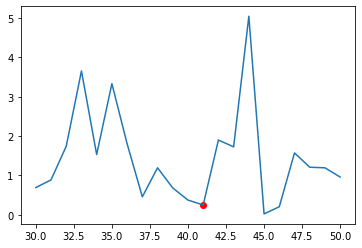

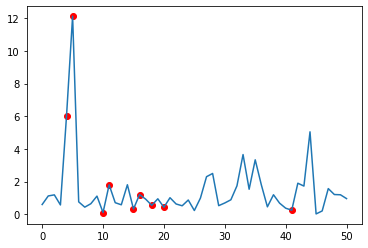

WMTS


c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC                 0.1
accuracy       0.571429
recall              0.6
Specificity         0.0
precision      0.923077
gmeans              0.0
RS                  inf
Name: 0, dtype: object

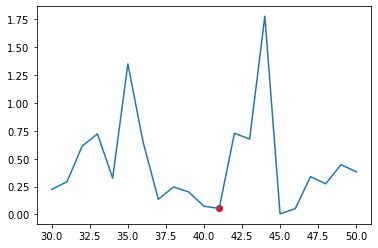

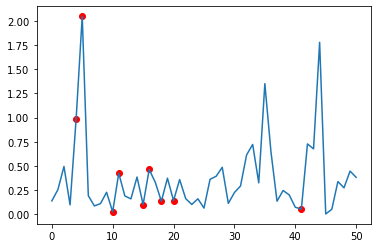

ImpAggMTSBag


c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC                0.05
accuracy       0.857143
recall              0.9
Specificity         0.0
precision      0.947368
gmeans              0.0
RS                  inf
Name: 0, dtype: object

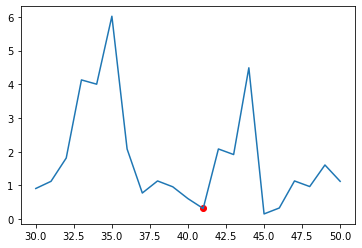

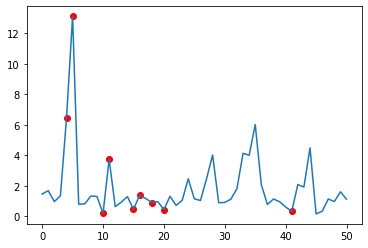

ImpAggWMTSBag


c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC                 0.1
accuracy       0.619048
recall             0.65
Specificity         0.0
precision      0.928571
gmeans              0.0
RS                  inf
Name: 0, dtype: object

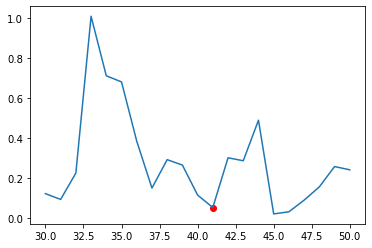

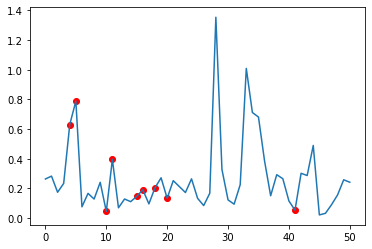

logistic


c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC                0.45
accuracy       0.952381
recall              1.0
Specificity         0.0
precision      0.952381
gmeans              0.0
RS                  inf
Name: 0, dtype: object

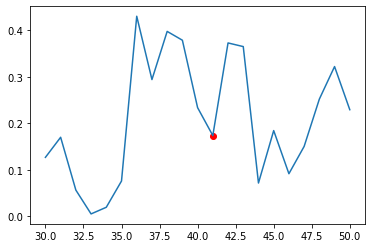

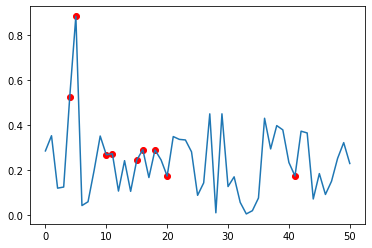

LGBM


c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC                 0.8
accuracy       0.761905
recall              0.8
Specificity         0.0
precision      0.941176
gmeans              0.0
RS                  inf
Name: 0, dtype: object

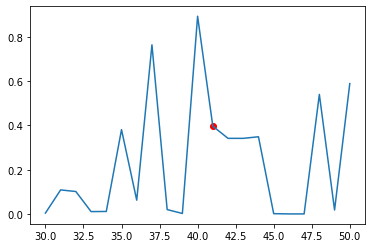

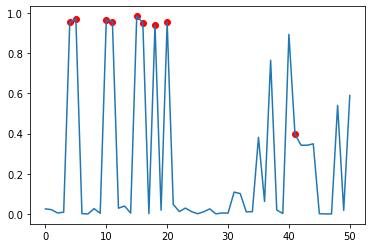

-------------------
1505
-------------------
MTS


AUC            0.478632
accuracy       0.371429
recall         0.230769
Specificity    0.777778
precision          0.75
gmeans         0.423659
RS             0.296703
Name: 0, dtype: object

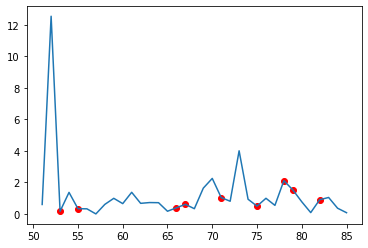

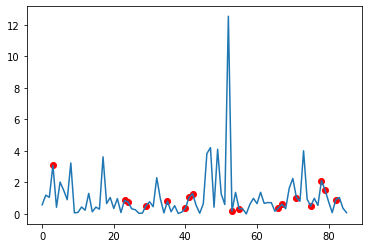

WMTS


AUC            0.423077
accuracy       0.371429
recall         0.346154
Specificity    0.444444
precision      0.642857
gmeans         0.392232
RS             0.778846
Name: 0, dtype: object

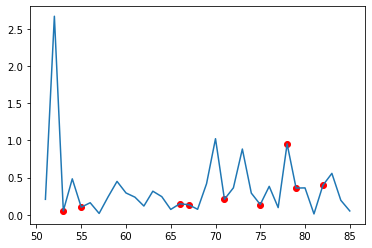

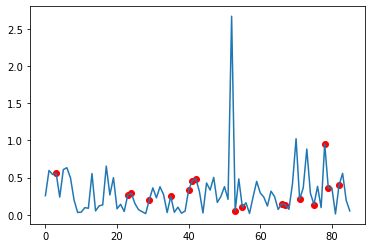

ImpAggMTSBag


AUC             0.42735
accuracy            0.6
recall         0.769231
Specificity    0.111111
precision      0.714286
gmeans         0.292353
RS             6.923077
Name: 0, dtype: object

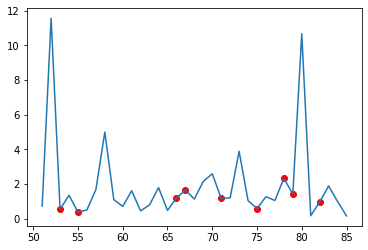

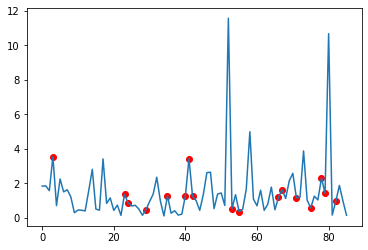

ImpAggWMTSBag


AUC            0.380342
accuracy       0.428571
recall              0.5
Specificity    0.222222
precision          0.65
gmeans         0.333333
RS                 2.25
Name: 0, dtype: object

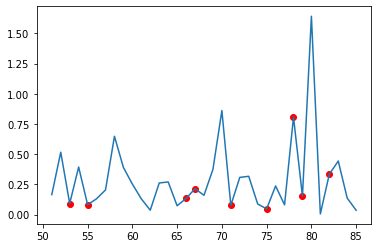

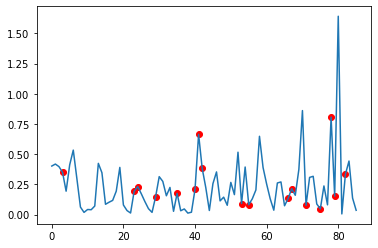

logistic


c:\Users\baseb\anaconda3\envs\convenient\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC             0.41453
accuracy       0.742857
recall              1.0
Specificity         0.0
precision      0.742857
gmeans              0.0
RS                  inf
Name: 0, dtype: object

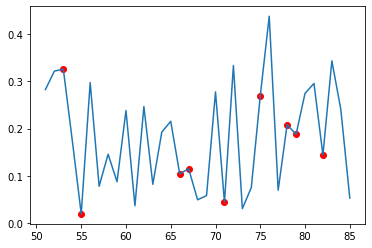

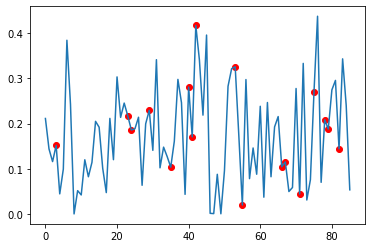

LGBM


AUC            0.478632
accuracy       0.657143
recall         0.846154
Specificity    0.111111
precision      0.733333
gmeans         0.306622
RS             7.615385
Name: 0, dtype: object

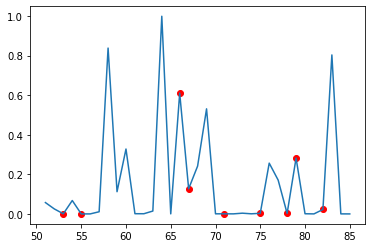

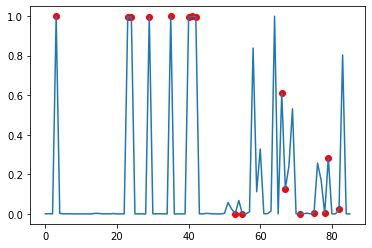

-------------------
1781
-------------------
MTS


AUC            0.575758
accuracy            0.2
recall         0.151515
Specificity         1.0
precision           1.0
gmeans         0.389249
RS             0.151515
Name: 0, dtype: object

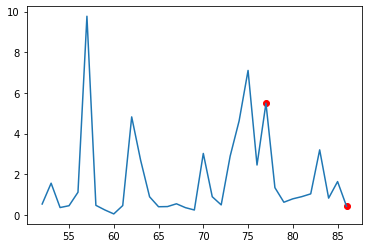

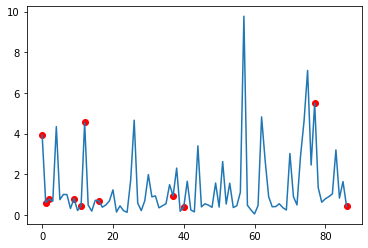

WMTS


AUC            0.636364
accuracy       0.857143
recall         0.878788
Specificity         0.5
precision      0.966667
gmeans         0.662868
RS             1.757576
Name: 0, dtype: object

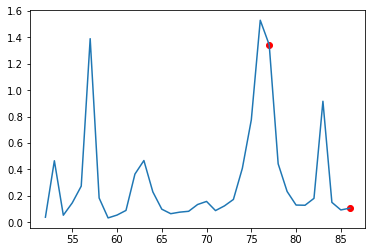

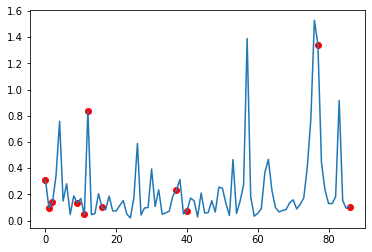

ImpAggMTSBag


AUC            0.712121
accuracy       0.628571
recall         0.636364
Specificity         0.5
precision      0.954545
gmeans         0.564076
RS             1.272727
Name: 0, dtype: object

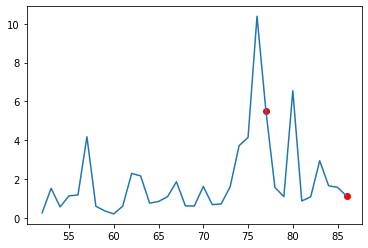

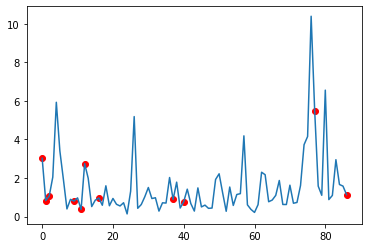

ImpAggWMTSBag


AUC            0.651515
accuracy       0.571429
recall         0.575758
Specificity         0.5
precision          0.95
gmeans         0.536543
RS             1.151515
Name: 0, dtype: object

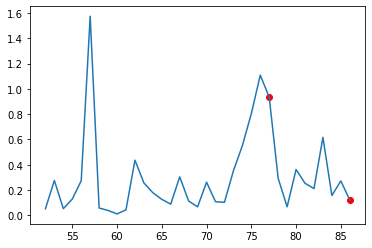

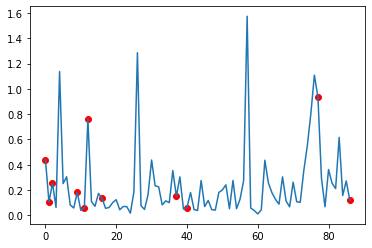

logistic


c:\Users\baseb\anaconda3\envs\convenient\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC            0.939394
accuracy       0.914286
recall         0.969697
Specificity         0.0
precision      0.941176
gmeans              0.0
RS                  inf
Name: 0, dtype: object

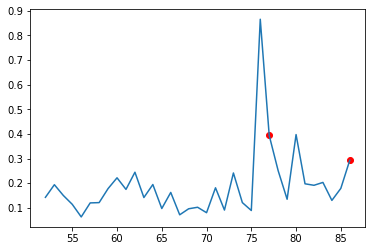

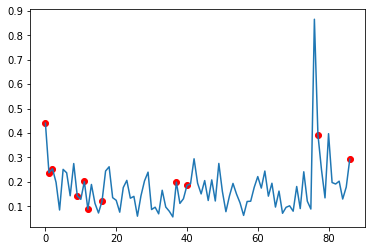

LGBM


AUC            0.742424
accuracy       0.742857
recall         0.757576
Specificity         0.5
precision      0.961538
gmeans         0.615457
RS             1.515152
Name: 0, dtype: object

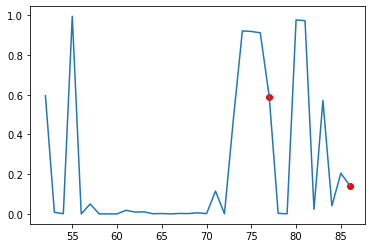

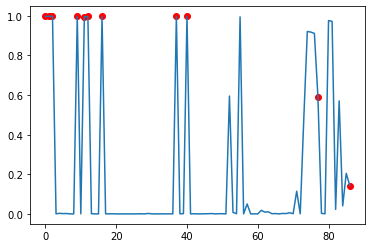

-------------------
1773
-------------------
MTS


c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC            0.515152
accuracy       0.657143
recall          0.69697
Specificity         0.0
precision          0.92
gmeans              0.0
RS                  inf
Name: 0, dtype: object

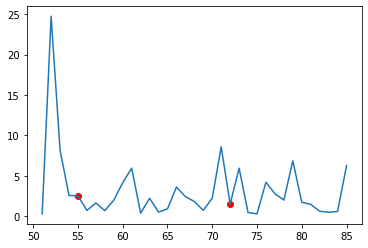

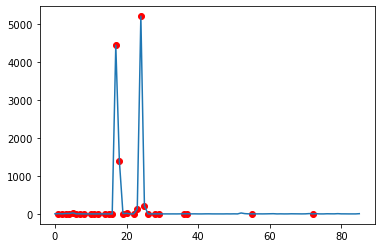

WMTS


c:\Users\baseb\Documents\github\修論\SMOTEMTSBag\MTSBag\code\func\my_func.py:574: RuntimeWarning: divide by zero encountered in double_scalars
  result_df['RS'][m] = (TP / (TP + FN)) / (TN / (TN + FP))


AUC            0.424242
accuracy       0.857143
recall         0.909091
Specificity         0.0
precision        0.9375
gmeans              0.0
RS                  inf
Name: 0, dtype: object

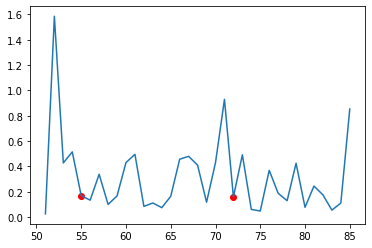

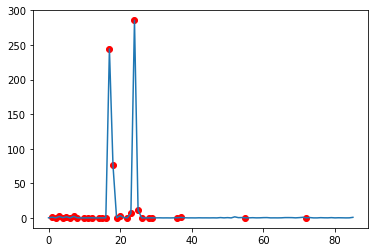

ImpAggMTSBag


AUC            0.318182
accuracy       0.257143
recall         0.212121
Specificity         1.0
precision           1.0
gmeans         0.460566
RS             0.212121
Name: 0, dtype: object

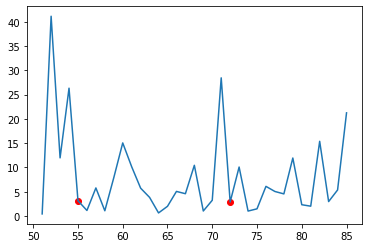

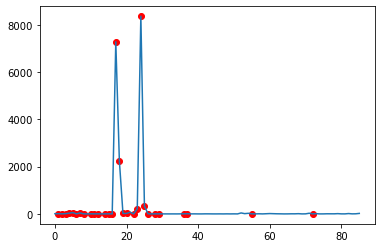

ImpAggWMTSBag


AUC            0.348485
accuracy       0.371429
recall         0.363636
Specificity         0.5
precision      0.923077
gmeans         0.426401
RS             0.727273
Name: 0, dtype: object

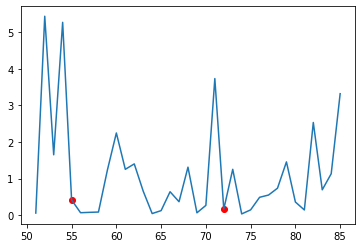

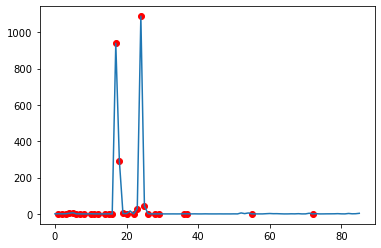

logistic


c:\Users\baseb\anaconda3\envs\convenient\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC            0.636364
accuracy       0.542857
recall         0.515152
Specificity         1.0
precision           1.0
gmeans         0.717741
RS             0.515152
Name: 0, dtype: object

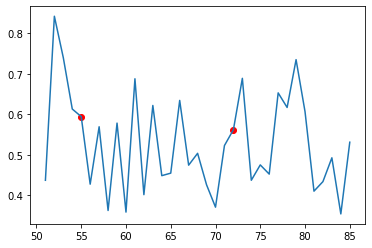

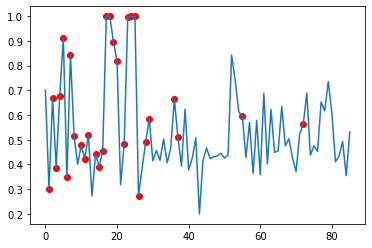

LGBM


AUC            0.863636
accuracy       0.657143
recall         0.636364
Specificity         1.0
precision           1.0
gmeans         0.797724
RS             0.636364
Name: 0, dtype: object

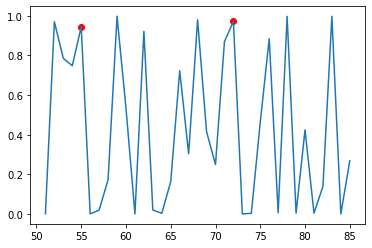

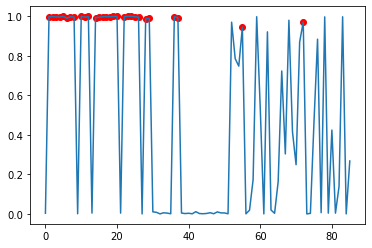

In [68]:
for user_id in use_users:
    print('-------------------')
    print(user_id)
    print('-------------------')
    exp(*create_X_y(user_id))